In [1]:
import pandas as pd

In [2]:
barley_path = "data/barley_yield_from_1982.csv"
climate_path = "data/climate_data_from_1982.parquet"


# Climate Data 

In [3]:
climate_data = pd.read_parquet(climate_path)
climate_data["time"] =   pd.to_datetime(climate_data["time"])
climate_data["year"] = climate_data["year"].astype(int)
climate_data['metric'] = climate_data['metric'].astype('category')
climate_data['code_dep'] = climate_data['code_dep'].astype(str).str.zfill(2)

# # Remove duplicates
# climate_data = climate_data.drop_duplicates()
# climate_data

In [4]:
climate_data.groupby("metric")["value"].describe()

/tmp/ipykernel_53742/1797636421.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  climate_data.groupby("metric")["value"].describe()


,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
daily_maximum_near_surface_air_temperature,4478308.0,288.603302,8.324001,2.532118e+02,2.824767e+02,287.805389,294.618103,319.311035
near_surface_air_temperature,4583500.0,283.964783,7.419903,2.455779e+02,2.786087e+02,283.396454,289.544655,307.876160
precipitation,4478308.0,0.000085,0.000172,-2.681981e-23,3.613616e-07,0.000013,0.000092,0.005103


In [5]:
dates_per_dep = climate_data.groupby("code_dep")["time"].nunique()
print(dates_per_dep.sort_values())
max_days = dates_per_dep.max()
print("Max number of days for a department:", max_days)

incomplete_deps = dates_per_dep[dates_per_dep < max_days]
print("Departments with missing days:")
print(incomplete_deps.to_string())


code_dep
01    25202
02    25202
03    25202
04    25202
05    25202
      ...  
87    25202
88    25202
89    25202
90    25202
91    25202
Name: time, Length: 89, dtype: int64
Max number of days for a department: 25202
Departments with missing days:
Series([], )


In [6]:
temps = [
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature"
]

mask = climate_data["metric"].isin(temps)
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"] - 273.15
mask = climate_data["metric"] == "precipitation"
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"] * 1000  # to mm
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"].mask(
    climate_data.loc[mask, "value"] < 0.001, 
    0
)


In [7]:
bad_temp = climate_data[
    (climate_data["metric"].isin(temps)) &
    ((climate_data["value"] < -50) | (climate_data["value"] > 60))
]

print("Extreme temp values found:", len(bad_temp))
climate_data.loc[bad_temp.index, "value"] = None
bad_p = climate_data[
    (climate_data["metric"] == "precipitation") &
    (climate_data["value"] > 500)  # >500 mm/day is impossible in France
]

print("Extreme rain values found:", len(bad_p))
climate_data.loc[bad_p.index, "value"] = None


Extreme temp values found: 0
Extreme rain values found: 0


In [8]:
climate_clean = climate_data.copy()

climate_clean.to_parquet("data/climate_clean.parquet", index=False)


# Climate Trends Over Years

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
climate_clean = pd.read_parquet("data/climate_clean.parquet")
climate_clean.head()

KeyboardInterrupt: 

In [10]:
hist_data = climate_clean[climate_clean["scenario"] == "historical"]
future_data = climate_clean[climate_clean["scenario"] != "historical"]


In [11]:
temps = [
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature"
]

hist_temps = hist_data[hist_data["metric"].isin(temps)]

# Mean and std per department-year
hist_year_dep = (
    hist_temps.groupby(["year","code_dep"])["value"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_temp_C", "std": "std_temp_C"})
)

# Mean and std across departments (national)
hist_year_nat = (
    hist_year_dep.groupby("year")["mean_temp_C"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_temp_C", "std": "std_temp_C"})
)
hist_year_nat.head()


,year,mean_temp_C,std_temp_C
0,1982,12.349283,2.156761
1,1983,11.194074,2.187116
2,1984,11.506407,2.068551
3,1985,11.309425,2.178289
4,1986,11.859694,1.966825


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

df = hist_year_nat.copy()

# --- Optional smoothing (5-year rolling mean) ---
df["smooth"] = df["mean_temp_C"].rolling(window=5, center=True).mean()

# --- Linear trend (°C / year) ---
X = df["year"].values.reshape(-1, 1)
y = df["mean_temp_C"].values
model = LinearRegression().fit(X, y)

trend = model.predict(X)
rate_per_decade = model.coef_[0] * 10  # °C per decade

# --- Plot ---
plt.figure(figsize=(11,6))
plt.plot(df["year"], df["mean_temp_C"], color="#1f77b4", alpha=0.4, linewidth=1.5, label="Annual Mean")
plt.plot(df["year"], df["smooth"], color="#1f77b4", linewidth=2.8, label="5-Year Smooth")
plt.plot(df["year"], trend, "--", color="red", linewidth=2, label=f"Trend ({rate_per_decade:.2f}°C / decade)")

# Style improvements
plt.title("France – National Average Annual Temperature (Historical)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'hist_year_nat' is not defined

In [8]:
coef = np.polyfit(hist_year_nat["year"], hist_year_nat["mean_temp_C"], 1)
trend_per_decade = coef[0] * 10

print("Historical warming trend ≈", round(trend_per_decade, 3), "°C per decade")

Historical warming trend ≈ 0.479 °C per decade


In [12]:
future_temps = future_data[future_data["metric"].isin(temps)]

# Mean + std per department-year AND scenario
future_year_dep = (
    future_temps.groupby(["scenario","year","code_dep"])["value"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_temp_C", "std": "std_temp_C"})
)

# National mean + std per scenario-year
future_year_nat = (
    future_year_dep.groupby(["scenario","year"])["mean_temp_C"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_temp_C", "std": "std_temp_C"})
)


: 

: 

: 

In [10]:
last_hist_year = hist_year_nat["year"].max()
print("Last historical year:", last_hist_year)


Last historical year: 2014


In [11]:
baseline_period = (1990, 2014)

baseline_mask = (
    (hist_year_nat["year"] >= baseline_period[0]) &
    (hist_year_nat["year"] <= baseline_period[1])
)

baseline = hist_year_nat.loc[baseline_mask, "mean_temp_C"].mean()
print("Baseline (1982-2014):", round(baseline, 3), "°C")


Baseline (1982-2014): 12.207 °C


In [12]:
# Historical
hist_year_nat["anomaly"] = hist_year_nat["mean_temp_C"] - baseline

# Future (apply to future_year_nat, which already groups per scenario)
future_year_nat["anomaly"] = future_year_nat["mean_temp_C"] - baseline



In [13]:
future_year_nat

,scenario,year,mean_temp_C,std_temp_C,anomaly
0,ssp1_2_6,2015,12.966093,2.137103,0.759192
1,ssp1_2_6,2016,13.098752,1.966624,0.891851
2,ssp1_2_6,2017,12.525651,2.118546,0.318750
3,ssp1_2_6,2018,12.765497,2.023188,0.558597
4,ssp1_2_6,2019,12.508302,2.056637,0.301401
...,...,...,...,...,...
103,ssp5_8_5,2046,14.729193,2.088437,2.522292
104,ssp5_8_5,2047,14.278464,2.032447,2.071564
105,ssp5_8_5,2048,13.970181,2.103590,1.763281
106,ssp5_8_5,2049,14.921721,1.974767,2.714821


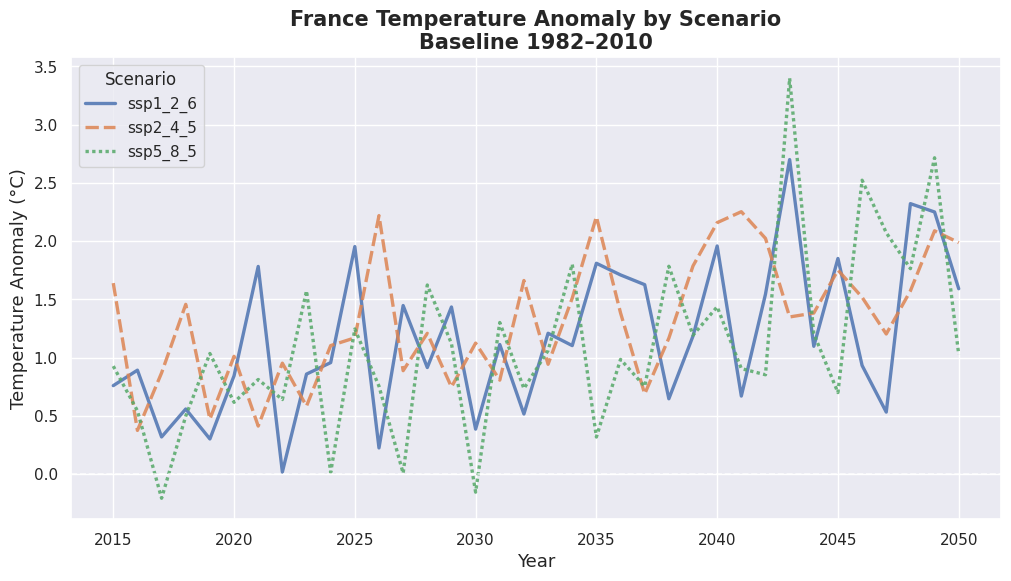

In [14]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.lineplot(
    data=future_year_nat[["scenario","year","anomaly"]],
    x="year", y="anomaly",
    hue="scenario", style="scenario",
    linewidth=2.4, alpha=0.85  # added thickness + lower opacity
)

plt.axhline(0, color="white", linestyle="--", linewidth=1.2, alpha=0.8)

plt.title("France Temperature Anomaly by Scenario\nBaseline 1982–2010",
          fontsize=15, weight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Temperature Anomaly (°C)", fontsize=13)
plt.legend(title="Scenario", fontsize=11, title_fontsize=12)

plt.show()


In [15]:
import geopandas as gpd

url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_FRA_2.json"
france_deps = gpd.read_file(url)
france_deps.head()


,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,FRA.1.1_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Ain,NA,NA,Département,Department,01,FR.AI,"MULTIPOLYGON (((5.6237 45.6133, 5.6149 45.6254..."
1,FRA.1.2_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Allier,Basses-Alpes,NA,Département,Department,03,FR.AL,"MULTIPOLYGON (((3.678 45.956, 3.6666 45.9612, ..."
2,FRA.1.3_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Ardèche,NA,NA,Département,Department,07,FR.AH,"MULTIPOLYGON (((4.1417 44.324, 4.1268 44.3377,..."
3,FRA.1.4_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Cantal,NA,NA,Département,Department,15,FR.CL,"MULTIPOLYGON (((3.0642 44.8203, 3.0483 44.8043..."
4,FRA.1.5_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Drôme,NA,NA,Département,Department,26,FR.DM,"MULTIPOLYGON (((5.4476 44.1368, 5.4384 44.1388..."


In [16]:
france_deps["code_dep"] = france_deps["CC_2"].str[-2:]

In [17]:
map_df = france_deps.merge(hist_year_dep, on="code_dep", how="left")


<Figure size 800x1000 with 0 Axes>

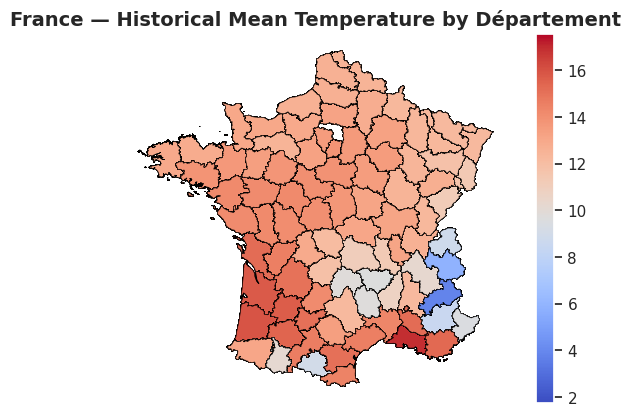

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
map_df.plot(column="mean_temp_C", cmap="coolwarm", linewidth=0.4,
            edgecolor="black", legend=True)

plt.title("France — Historical Mean Temperature by Département",
          fontsize=14, weight="bold")
plt.axis("off")
plt.show()


In [19]:
baseline_period = (1990,2014)
baseline_dep = (
    hist_year_dep
    .query("@baseline_period[0] <= year <= @baseline_period[1]")
    .groupby("code_dep")["mean_temp_C"]
    .mean()
    .reset_index()
    .rename(columns={"mean_temp_C": "baseline_temp_C"})
)
baseline_dep.head()

,code_dep,baseline_temp_C
0,01,11.894073
1,02,12.124175
2,03,12.486420
3,04,7.705419
4,05,3.044932


In [20]:
future_with_base = future_year_dep.merge(baseline_dep, on="code_dep", how="left")
future_with_base["anomaly"] = future_with_base["mean_temp_C"] - future_with_base["baseline_temp_C"]
future_with_base.head()


,scenario,year,code_dep,mean_temp_C,std_temp_C,baseline_temp_C,anomaly
0,ssp1_2_6,2015,01,12.550575,8.409675,11.894073,0.656502
1,ssp1_2_6,2015,02,13.206440,8.253116,12.124175,1.082265
2,ssp1_2_6,2015,03,13.010260,8.328366,12.486420,0.523840
3,ssp1_2_6,2015,04,8.244396,7.648226,7.705419,0.538978
4,ssp1_2_6,2015,05,3.630913,8.258097,3.044932,0.585982


In [21]:
def slope_per_decade(df):
    # fit slope in °C per year
    coef = np.polyfit(df["year"], df["anomaly"], 1)[0]
    return coef * 10  # convert to °C / decade

warming_rate = (
    future_with_base
    .groupby(["scenario", "code_dep"])
    .apply(slope_per_decade)
    .reset_index()
    .rename(columns={0: "warming_per_decade"})
)

warming_rate.head()


/tmp/ipykernel_147131/2977583861.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  future_with_base


,scenario,code_dep,warming_per_decade
0,ssp1_2_6,01,0.350004
1,ssp1_2_6,02,0.245143
2,ssp1_2_6,03,0.330689
3,ssp1_2_6,04,0.446046
4,ssp1_2_6,05,0.465739


In [22]:
gdf_trend = france_deps.merge(warming_rate, on="code_dep", how="left")


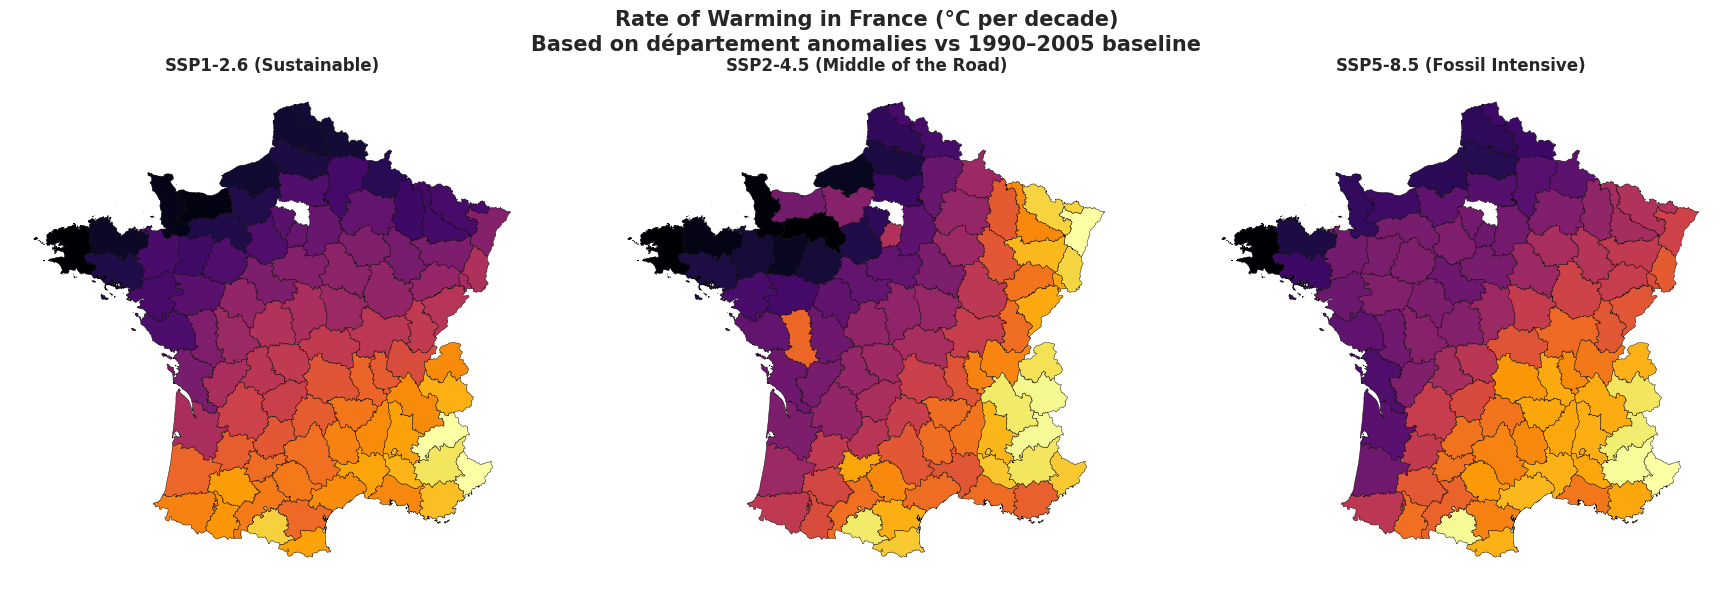

In [23]:
import matplotlib.pyplot as plt

scens = ["ssp1_2_6", "ssp2_4_5", "ssp5_8_5"]
titles = {
    "ssp1_2_6": "SSP1-2.6 (Sustainable)",
    "ssp2_4_5": "SSP2-4.5 (Middle of the Road)",
    "ssp5_8_5": "SSP5-8.5 (Fossil Intensive)"
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, scen in zip(axes, scens):
    subset = gdf_trend[gdf_trend["scenario"] == scen]
    
    subset.plot(
        column="warming_per_decade",
        cmap="inferno",  # Good warming palette
        linewidth=0.3,
        edgecolor="black",
        legend=False,
        ax=ax,
    )
    
    ax.set_title(titles[scen], fontsize=12, weight="bold")
    ax.axis("off")

fig.suptitle("Rate of Warming in France (°C per decade)\nBased on département anomalies vs 1990–2005 baseline",
             fontsize=15, weight="bold")

plt.tight_layout()


## Crop Season Indicators

In [24]:
climate_crop = climate_clean[
    climate_clean["time"].dt.month.isin([3,4,5,6,7,8])
]


In [25]:
climate_crop["metric"].unique()

['near_surface_air_temperature', 'daily_maximum_near_surface_air_temperature', 'precipitation']
Categories (3, object): ['daily_maximum_near_surface_air_temperature', 'near_surface_air_temperature', 'precipitation']

In [26]:
base = 5.0

# Keep only mean temp rows
crop_mean = climate_crop[climate_crop["metric"]=="near_surface_air_temperature"]
crop_max = climate_crop[climate_crop["metric"]=="daily_maximum_near_surface_air_temperature"]
crop_precip = climate_crop[climate_crop["metric"]=="precipitation"]
hist_crop_max = crop_max[crop_max["scenario"]=="historical"]

# Merge daily mean, max, precipitation
crop_daily = (
    crop_mean[["scenario","year","code_dep","time","value"]].rename(columns={"value":"Tmean"})
    .merge(
        crop_max[["scenario","year","code_dep","time","value"]].rename(columns={"value":"Tmax"}),
        on=["scenario","year","code_dep","time"]
    )
    .merge(
        crop_precip[["scenario","year","code_dep","time","value"]].rename(columns={"value":"P"}),
        on=["scenario","year","code_dep","time"],
        how="left"
    )
)
crop_daily["P"] = crop_daily["P"].fillna(0.0)


# GDD per year, scenario, and department
GDD = (
    crop_mean
    .assign(GDD=lambda df: np.maximum(df["value"] - base, 0))
    .groupby(["scenario", "year", "code_dep"])["GDD"]
    .sum()
    .reset_index()
)

HeatStress = (
    crop_max
    .assign(stress=lambda df: df["value"] > 32)
    .groupby(["scenario", "year", "code_dep"])["stress"]
    .sum()
    .reset_index()
    .rename(columns={"stress":"heat_stress_days"})
)
TXx = (
    crop_max
    .groupby(["scenario", "year", "code_dep"])["value"]
    .max()
    .reset_index()
    .rename(columns={"value":"TXx_crop_max"})
)

# Percentile threshold per dept (based on historical)
thr95 = (
    hist_crop_max.groupby("code_dep")["value"]
    .quantile(0.95)
    .reset_index()
    .rename(columns={"value":"thr95"})
)
Heatwave = (
    crop_max.merge(thr95, on="code_dep", how="left")
    .assign(hw=lambda df: df["value"] > df["thr95"])
    .groupby(["scenario","year","code_dep"])["hw"]
    .sum()
    .reset_index()
    .rename(columns={"hw":"heatwave_days"})
)

Precip = (
    crop_precip.groupby(["scenario","year","code_dep"])["value"]
    .sum()
    .reset_index()
    .rename(columns={"value":"precip_sum"})
)

PrecipVar = (
    crop_precip.groupby(["scenario","code_dep"])["value"]
    .std()
    .reset_index()
    .rename(columns={"value":"precip_std"})
)

crop_daily["Tmin"] = 2 * crop_daily["Tmean"] - crop_daily["Tmax"]
deltaT = (crop_daily["Tmax"] - crop_daily["Tmin"]).clip(lower=0)
crop_daily["ET0"] = 0.0023 * (crop_daily["Tmean"] + 17.8) * np.sqrt(deltaT)

ET0 = (
    crop_daily.groupby(["scenario","year","code_dep"])["ET0"]
    .sum()
    .reset_index()
    .rename(columns={"ET0":"ET0_sum"})
)


In [27]:
from functools import reduce
dfs = [GDD, HeatStress, TXx, ET0]

crop_indicators = reduce(
    lambda left, right: pd.merge(left, right, on=["scenario","year","code_dep"], how="left"),
    dfs
)

climate_full = (
    crop_indicators
    .merge(Precip, on=["scenario","year","code_dep"], how="left")
    .merge(PrecipVar, on=["scenario","code_dep"], how="left")
)
climate_full


,scenario,year,code_dep,GDD,heat_stress_days,TXx_crop_max,ET0_sum,precip_sum,precip_std
0,historical,1982,01,1514.790771,2.0,32.390900,40.885181,15.091568,0.136944
1,historical,1982,02,1568.512085,9.0,34.840485,41.513168,12.913468,0.137489
2,historical,1982,03,1560.062134,5.0,33.608002,43.026932,14.694757,0.149206
3,historical,1982,04,829.285828,0.0,24.251587,34.915390,14.527946,0.164256
4,historical,1982,05,377.517944,0.0,19.528961,26.887497,19.175266,0.172436
...,...,...,...,...,...,...,...,...,...
12544,ssp5_8_5,2050,87,1717.961426,9.0,38.711334,40.640320,26.118011,0.186905
12545,ssp5_8_5,2050,88,1657.697021,2.0,35.246277,40.086090,22.323778,0.163180
12546,ssp5_8_5,2050,89,1804.620850,4.0,38.175598,41.165005,33.222610,0.235654
12547,ssp5_8_5,2050,90,1645.087158,2.0,34.049866,40.809433,8.515433,0.060794


In [39]:
# 1) GDD peak ~ 1150–1500, penalty beyond 900 and 1800
def score_gdd(gdd):
    # Smooth bell with asymmetric penalty
    optimal_low, optimal_high = 1150, 1500
    min_gdd, max_gdd = 900, 1800
    
    # Normalize 0–1 inside general bounds
    g = (gdd - min_gdd) / (max_gdd - min_gdd)
    g = np.clip(g, 0, 1)
    
    # Peak plateau in optimal zone
    g[gdd < optimal_low] *= (gdd[gdd < optimal_low] - min_gdd) / (optimal_low - min_gdd + 1e-9)
    g[gdd > optimal_high] *= (max_gdd - gdd[gdd > optimal_high]) / (max_gdd - optimal_high + 1e-9)
    return g

# 2) Precip best ~ 250–450 mm, penalty on both sides (trapezoid)
def score_precip(precip):
    a, b = 250, 450      # optimal window
    min_p, max_p = 100, 700
    
    p = (precip - min_p) / (max_p - min_p)
    p = np.clip(p, 0, 1)
    
    # Side penalty if outside optimal band
    p[precip < a] *= (precip[precip < a] - min_p) / (a - min_p + 1e-9)
    p[precip > b] *= (max_p - precip[precip > b]) / (max_p - b + 1e-9)
    return p

# 3) Heat stress penalty: >29°C
def penalty_heat(heat_days):
    # exponential: 0 stress = 1, many days → 0
    return np.exp(-0.12 * heat_days)

# 4) Extreme TX penalty > 34°C
def penalty_extreme(tx):
    # logistic sigmoid penalty
    return 1 / (1 + np.exp(0.6 * (tx - 34)))

def penalty_var(std):
    # strong penalty above ~3mm/day of variability
    return np.exp(-0.35 * np.clip(std - 2.0, 0, None))

def score_water_balance(wbr):
    w = np.asarray(wbr, float)
    score = np.ones_like(w)
    drought = w < 0.8
    score[drought] = w[drought] / 0.8
    excess = w > 1.2
    score[excess] = (2.0 - w[excess]) / (2.0 - 1.2)
    return np.clip(score, 0, 1)

def score_TPR(tpr):
    t = np.asarray(tpr, float)
    score = np.ones_like(t)

    # define "reasonable" central band based on quantiles
    q25, q50, q75 = np.quantile(t[~np.isnan(t)], [0.25, 0.5, 0.75])

    # left side (too wet / too low TPR)
    low = t < q25
    score[low] = (t[low] - t.min()) / (q25 - t.min() + 1e-9)

    # middle band: best
    mid = (t >= q25) & (t <= q75)
    score[mid] = 1.0

    # right side (too dry / too high TPR)
    high = t > q75
    score[high] = (t.max() - t[high]) / (t.max() - q75 + 1e-9)

    return np.clip(score, 0, 1)

In [40]:
# 1) Simple temperature–precipitation ratio
climate_full["TPR"] = climate_full["GDD"] / (climate_full["precip_sum"] + 1e-6)
climate_full["SWSF_TPR"] = score_TPR(climate_full["TPR"])


In [42]:
climate_full["S1_mixed_barley"] = (
    0.30 * score_gdd(climate_full["GDD"]) +           # growth potential
    0.35 * climate_full["SWSF_TPR"] +                 # water balance proxy
    0.20 * penalty_heat(climate_full["heat_stress_days"]) +
    0.10 * penalty_extreme(climate_full["TXx_crop_max"]) +
    0.05 * penalty_var(climate_full["precip_std"])
)


In [43]:
baseline_period = (1990, 2005)

hist_extracted = climate_full.query(
    "scenario == 'historical' and @baseline_period[0] <= year <= @baseline_period[1]"
)

hist_scores = hist_extracted.groupby("code_dep")[["S1_mixed_barley"]].mean().reset_index()
hist_map = france_deps.merge(hist_scores, on="code_dep", how="left")


In [1]:
barley_data = pd.read_csv(barley_path, delimiter=";", index_col=0).reset_index()
dep_map = (
    climate_clean[["nom_dep", "code_dep"]]
    .drop_duplicates()
    .set_index("nom_dep")["code_dep"]
    .to_dict()
)

barley_data["code_dep"] = barley_data["department"].map(dep_map)
barley_data["year"] = barley_data["year"].astype(int)

# Compute yield if missing but we have area & production
mask = barley_data["yield"].isna() & barley_data["production"].notna() & barley_data["area"].notna()

barley_data.loc[mask, "yield"] = barley_data.loc[mask, "production"] / barley_data.loc[mask, "area"]

barley_data = barley_data[~(barley_data["yield"].isna())]

# If production is missing but yield and area exist → compute it
mask_prod = barley_data["production"].isna() & barley_data["yield"].notna() & barley_data["area"].notna()
barley_data.loc[mask_prod, "production"] = barley_data.loc[mask_prod, "yield"] * barley_data.loc[mask_prod, "area"]



NameError: name 'pd' is not defined

In [16]:
barley_data.to_csv("data/barley_data_clean.csv")

In [45]:
baseline_period = (1990, 2005)

yield_hist = barley_data.query(
    "@baseline_period[0] <= year <= @baseline_period[1]"
)

yield_dep_mean = (
    yield_hist.groupby("code_dep")["yield"]
    .mean()
    .reset_index()
    .rename(columns={"yield": "mean_yield"})
)
yield_dep_mean.head()


,code_dep,mean_yield
0,01,5.459815
1,02,7.001209
2,03,4.991563
3,04,3.792743
4,05,3.818125


In [46]:
yield_climate = yield_dep_mean.merge(hist_scores, on="code_dep", how="left")
yield_climate.head()


,code_dep,mean_yield,S1_mixed_barley
0,01,5.459815,0.775235
1,02,7.001209,0.685334
2,03,4.991563,0.711370
3,04,3.792743,NaN
4,05,3.818125,NaN


In [47]:
yield_climate[["mean_yield","S1_mixed_barley"]].corr(method="pearson")


,mean_yield,S1_mixed_barley
mean_yield,1.000000,0.223834
S1_mixed_barley,0.223834,1.000000


In [48]:
# Filter climate only for historical
clim_hist = climate_full[climate_full["scenario"]=="historical"].copy()

# Merge year + code_dep with yields
df_ml = clim_hist.merge(barley_data, on=["year","code_dep"], how="inner")

# Keep only relevant columns
features = ["GDD","SWSF_TPR","heat_stress_days","TXx_crop_max","precip_std"]
target = "yield"

df_ml = df_ml.dropna(subset=features+[target])
df_ml.head()


,scenario,year,code_dep,GDD,heat_stress_days,TXx_crop_max,ET0_sum,precip_sum,precip_std,WBR,SWSF,S1_mixed_barley,TPR,SWSF_TPR,index,department,yield,area,production
0,historical,1982,01,1514.790771,2.0,32.390900,40.885181,15.091568,0.136944,0.369121,0.461401,0.824574,100.373314,1.0,82,Ain,3.95008,16065.0,63458.0
1,historical,1982,02,1568.512085,9.0,34.840485,41.513168,12.913468,0.137489,0.311069,0.388837,0.677520,121.463257,1.0,201,Aisne,6.14227,53700.0,329840.0
2,historical,1982,03,1560.062134,5.0,33.608002,43.026932,14.694757,0.149206,0.341525,0.426906,0.741586,106.164536,1.0,320,Allier,3.63842,32211.0,117197.0
7,historical,1982,08,1486.745361,8.0,33.978851,40.305443,9.844910,0.094697,0.244258,0.305322,0.722478,151.016647,1.0,796,Ardennes,5.67871,31000.0,176040.0
10,historical,1982,11,1890.572998,0.0,31.752472,43.819321,15.381859,0.196413,0.351029,0.438786,0.588816,122.909256,1.0,1153,Aude,2.81983,6050.0,17060.0


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = df_ml[features].values
y = df_ml[target].values

# Split department-level shuffling but year random
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=3,
    random_state=42
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print("R2:", r2_score(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


R2: 0.5165299533717925
RMSE: 0.9312175009854842


<Axes: title={'center': 'Feature Importance'}>

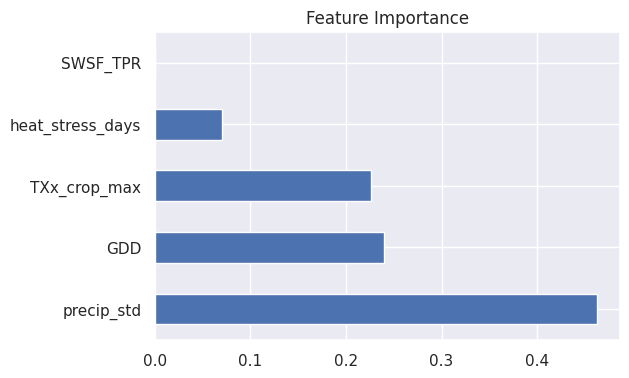

In [ ]:
import pandas as pd

imp = pd.Series(rf.feature_importances_, index=features)
imp.sort_values(ascending=False).plot(kind="barh", figsize=(6,4), title="Feature Importance")

In [52]:
imp = pd.Series(rf.feature_importances_, index=features)
print(imp.sort_values(ascending=False))


precip_std          0.462995
GDD                 0.239790
TXx_crop_max        0.226511
heat_stress_days    0.070704
SWSF_TPR            0.000000
dtype: float64


In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Copy to avoid modifying original
S1_df = clim_hist.copy()

# Define beneficial and harmful features
beneficial = ["GDD"]
harmful = ["precip_std", "TXx_crop_max", "heat_stress_days"]

# Normalize beneficial positively
S1_df[beneficial] = scaler.fit_transform(S1_df[beneficial])

# Normalize harmful features, then invert scale (1=good, 0=bad)
for feat in harmful:
    S1_df[feat] = scaler.fit_transform(S1_df[[feat]])
    S1_df[feat] = 1 - S1_df[feat]   # invert (lower risk → higher score)


In [54]:
w = {"precip_std":0.44, "GDD":0.23, "TXx_crop_max":0.22, "heat_stress_days":0.07}

S1_df["S1_RF"] = (
    w["GDD"] * S1_df["GDD"] +
    w["precip_std"] * S1_df["precip_std"] +
    w["TXx_crop_max"] * S1_df["TXx_crop_max"] +
    w["heat_stress_days"] * S1_df["heat_stress_days"]
)


In [55]:
S1_hist = (
    S1_df.groupby("code_dep")["S1_RF"]
    .mean()
    .reset_index()
    .sort_values("S1_RF", ascending=False)
)


In [56]:
yield_climate_S1 = yield_dep_mean.merge(S1_hist, on="code_dep", how="left")
yield_climate_S1[["mean_yield","S1_RF"]].corr()


,mean_yield,S1_RF
mean_yield,1.000000,0.249808
S1_RF,0.249808,1.000000


In [59]:
future_df = climate_full[climate_full["scenario"] != "historical"].copy()
features = ["GDD","SWSF_TPR","heat_stress_days","TXx_crop_max","precip_std"]

# Keep only the features used by RF
future_df = future_df[["scenario","year","code_dep","GDD","SWSF_TPR","heat_stress_days","TXx_crop_max","precip_std"]]
future_df["predicted_yield"] = rf.predict(future_df[features])


/home/fotis/M2AD/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [60]:
future_df_mid = future_df[future_df["year"] >= 2035]

future_dep_yield = (
    future_df_mid.groupby(["scenario","code_dep"])["predicted_yield"]
    .mean()
    .reset_index()
)


In [61]:
yield_compare = future_dep_yield.merge(yield_dep_mean, on="code_dep", how="left")
yield_compare["delta"] = (yield_compare["predicted_yield"] - yield_compare["mean_yield"]) / yield_compare["mean_yield"]


In [62]:
def classify_risk(d):
    if d >= 0.10:    return "Promising"
    if d >= -0.05:   return "Low Risk"
    if d >= -0.15:   return "Medium Risk"
    return "High Risk"

yield_compare["Risk"] = yield_compare["delta"].apply(classify_risk)


In [63]:
yield_compare.groupby("scenario")["Risk"].value_counts()


scenario  Risk       
ssp1_2_6  Low Risk       27
          Promising      25
          Medium Risk    20
          High Risk      17
ssp2_4_5  Promising      30
          Low Risk       25
          Medium Risk    19
          High Risk      15
ssp5_8_5  Medium Risk    29
          Promising      24
          Low Risk       22
          High Risk      14
Name: count, dtype: int64

In [68]:
geo_risk = france_deps.merge(yield_compare,
                             on="code_dep",
                             how="left")
risk_colors = {
    "Promising": "#2ca02c",
    "Low Risk": "#98df8a",
    "Medium Risk": "#ffbf00",
    "High Risk": "#d62728"
}


/tmp/ipykernel_147131/4239156435.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  g.plot(column="Risk",


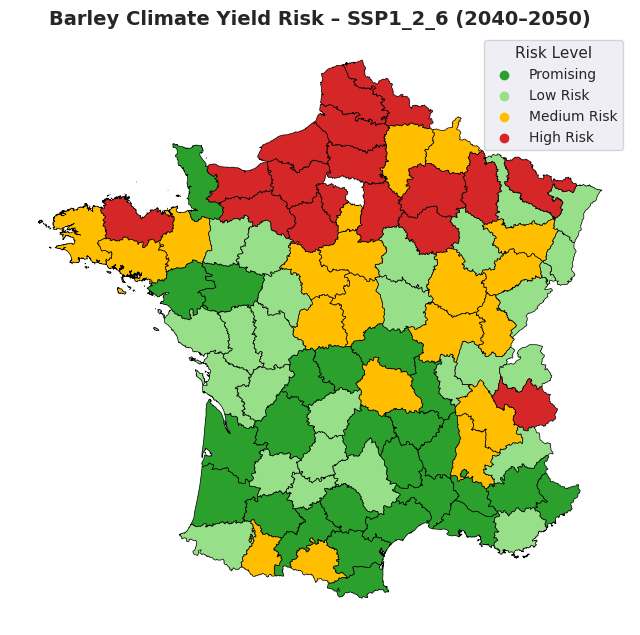

/tmp/ipykernel_147131/4239156435.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  g.plot(column="Risk",


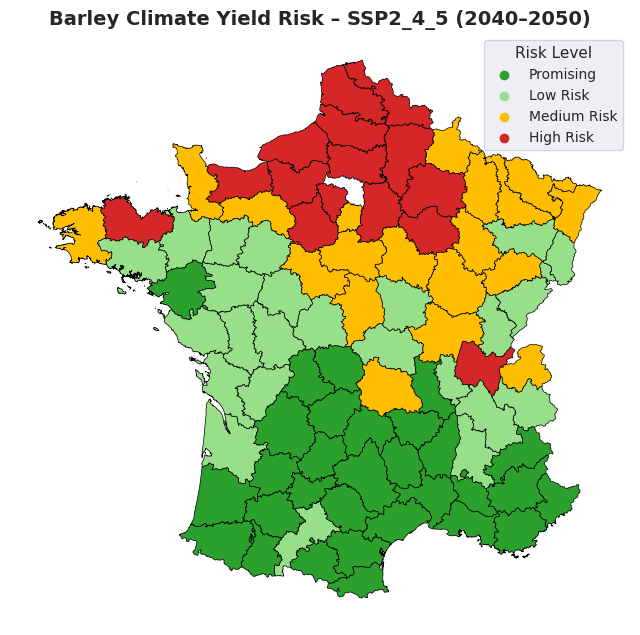

/tmp/ipykernel_147131/4239156435.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  g.plot(column="Risk",


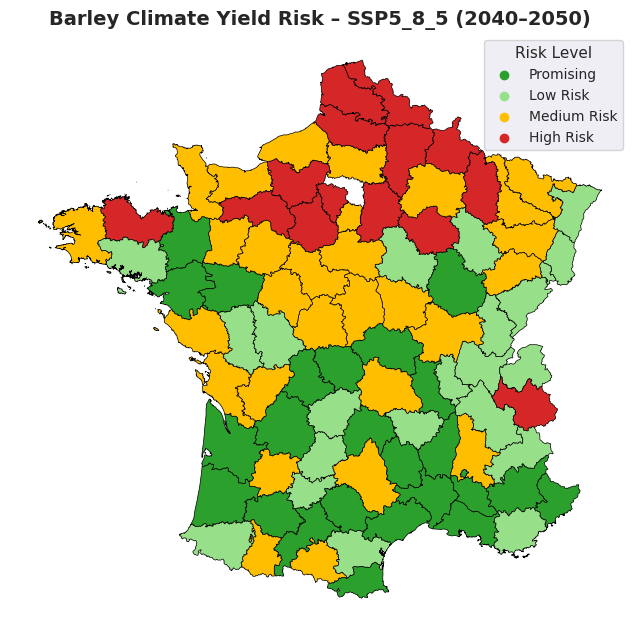

In [69]:
import matplotlib.pyplot as plt

def plot_scenario(sc):
    g = geo_risk[geo_risk["scenario"] == sc]
    
    fig, ax = plt.subplots(figsize=(8, 10))
    
    g.plot(column="Risk",
           cmap=None,
           color=g["Risk"].map(risk_colors),
           linewidth=0.5,
           edgecolor="black",
           ax=ax)
    
    ax.set_title(f"Barley Climate Yield Risk – {sc.upper()} (2040–2050)", fontsize=14, weight='bold')
    ax.axis("off")

    # Create legend manually
    for label, color in risk_colors.items():
        ax.scatter([], [], color=color, label=label)
    ax.legend(title="Risk Level", fontsize=10, title_fontsize=11)
    plt.show()

for sc in ["ssp1_2_6", "ssp2_4_5", "ssp5_8_5"]:
    plot_scenario(sc)


In [66]:
future_df = climate_full[climate_full["scenario"] != "historical"].copy()
features = ["GDD","SWSF_TPR","heat_stress_days","TXx_crop_max","precip_std"]

# Keep only the features used by RF
future_df = future_df[["scenario","year","code_dep","GDD","SWSF_TPR","heat_stress_days","TXx_crop_max","precip_std"]]
future_df["predicted_yield"] = rf.predict(future_df[features])


/home/fotis/M2AD/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
